In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#### Carica le immagini

In [2]:
img1 = cv2.imread("../../Materiale/Prove/non_colorato.png")
img2 = cv2.imread("../../Materiale/Prove/colorato.png")

# Verifica il caricamento corretto
if img1 is None or img2 is None:
    print("Errore: una delle immagini non è stata caricata correttamente.")
    exit()

#### Converti in scala di grigi

In [3]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#### Inizializza ORB

In [4]:
orb = cv2.ORB_create(nfeatures=5000)

# Trova keypoints e descrittori
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

#### Controlla che siano stati trovati descrittori validi
Controlla se il rilevamento delle feature ha avuto successo.  
Se non sono stati trovati descrittori (`None`), il programma si interrompe per evitare errori successivi.

In [5]:
if des1 is None or des2 is None:
    print("Errore: non sono stati trovati descrittori in una delle immagini.")
    exit()

#### Creazione del Matcher e KNN Matching
Matcher con BFMatcher e KNN Matching (2 match per ogni keypoint).  
**_Cosa fa?_**
- `cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)`: crea un matcher basato su distanza di Hamming, adatto per ORB.
- `crossCheck=False` perché vogliamo usare KNN Matching invece del solito "match diretto".
- `bf.knnMatch(des1, des2, k=2)`: per ogni descrittore di img1, trova i 2 descrittori migliori in img2.

Questo è utile per applicare il Lowe's Ratio Test e ridurre i falsi positivi.

In [6]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

#### Lowe’s Ratio Test
**_Come funziona?_**
1. Per ogni feature nell'immagine 1, troviamo i due migliori match nell'immagine 2.
2. Confrontiamo la distanza del primo match (m) con quella del secondo match (n).
3. Se la distanza del miglior match è molto minore rispetto alla seconda, allora il match è considerato affidabile. Se $m.distance<ratio\times n.distance$, allora $m$ è un match valido

In [7]:
good_matches = []
ratio_thresh = 0.75  # Soglia standard suggerita da Lowe (0.75)

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

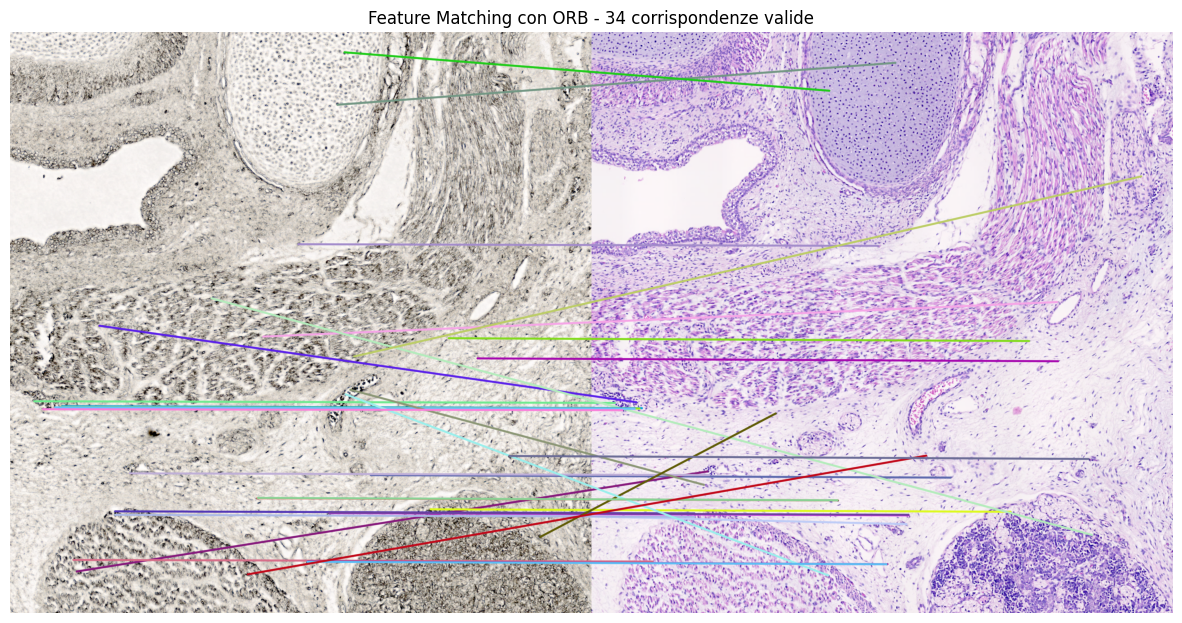

In [8]:
matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                              matchesThickness=5)

# Visualizza il risultato
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matching con ORB - {len(good_matches)} corrispondenze valide")
plt.axis("off")
plt.show()

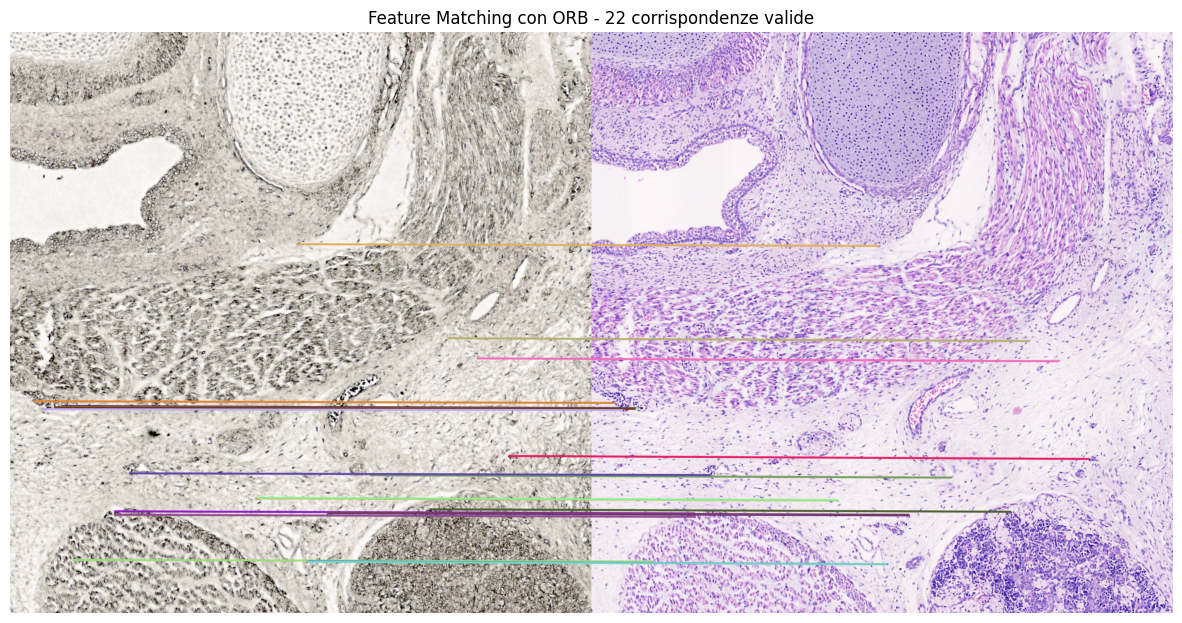

In [9]:
# Filtra i match in base alla distanza euclidea tra keypoints corrispondenti
filtered_matches = []
max_distance = 50  # Distanza massima accettabile tra feature corrispondenti

for match in good_matches:
    pt1 = np.array(kp1[match.queryIdx].pt)  # Feature nell'immagine 1
    pt2 = np.array(kp2[match.trainIdx].pt)  # Feature corrispondente nell'immagine 2

    euclidean_dist = np.linalg.norm(pt1 - pt2)  # Calcola la distanza euclidea

    if euclidean_dist < max_distance:
        filtered_matches.append(match)

# Disegna i match non filtrati
# matched_img = cv2.drawMatches(img1, kp1, img2, kp2, sorted(lista, key=lambda x: x.distance)[:10], None,
#                               flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
#                               matchesThickness=5)

matched_img = cv2.drawMatches(img1, kp1, img2, kp2, filtered_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                              matchesThickness=5)

# Visualizza il risultato
plt.figure(figsize=(15, 8))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title(f"Feature Matching con ORB - {len(filtered_matches)} corrispondenze valide")
plt.axis("off")
plt.show()